# BASE DE DADOS POLITICAS PÚBLICAS CEPAL 

## Importando as Bibliotecas

In [1]:
from selenium import webdriver
import requests
import time
import os
from pathlib import Path
import investpy as ipy # documentação: https://investpy.readthedocs.io/introduction.html
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from math import pi
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats  as stats
from scipy.stats import pearsonr
from sklearn import preprocessing
import seaborn as sns; sns.set()
from datetime import datetime
import calendar
import os
from os import listdir
from os.path import isfile, join
import plotly.graph_objects as go
pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

pd.options.display.float_format = '{:,.2f}'.format

## Pegar os códigos ISO de cada país

In [2]:
url = 'https://www.sport-histoire.fr/pt/Geografia/Paises_por_ordem_alfabetica.php'
html = requests.get(url).content
df_list = pd.read_html(html)
Pais_Continente = df_list[-1]
Pais_Continente
url = 'https://www.sport-histoire.fr/pt/Geografia/Codigos_ISO_Paises.php'
html = requests.get(url).content
df_list = pd.read_html(html)
Pais_ISO = df_list[-1]
America = Pais_ISO.merge(Pais_Continente)
lista = ['México','Venezuela','Argentina','Peru','Colômbia','Equador','Brasil','Chile','Uruguai','Bolívia']
selecao = America[America['País'].isin(lista)].reset_index(drop=True)
selecao = selecao['Código ISO (3 letras)']
selecao

0    ARG
1    BOL
2    BRA
3    CHL
4    COL
5    ECU
6    MEX
7    PER
8    URY
9    VEN
Name: Código ISO (3 letras), dtype: object

# Funções

## Criar função para verificar se o download do excel foi concluído

In [3]:
def download_wait(path_to_downloads):
    seconds = 0
    dl_wait = True
    while dl_wait and seconds < 10:
        time.sleep(0.2)
        dl_wait = False
        for fname in os.listdir(path_to_downloads):
            if fname.endswith('.xlsx'):
                dl_wait = True
        seconds += 1
    return seconds

## Definindo a função que seleciona a politica  para cada politica filho e neto

Nos referimos à política Pai como a política economica macro de um país dentre Política Fiscal, Política Monetária, e Política de Negócios (Classificação da CEPAL)

In [4]:
def retorna_politica_pai(EQ):
    EQ['General Policy']=EQ['Amount']
    nome=''
    for i in range(len(EQ['Policy'])):
        try:
            if type(EQ['Policy'].iloc[i]) == float:
                EQ['General Policy'].iloc[i]=nome
            elif EQ['Policy'].iloc[i].split()[0].split('.')[0].isnumeric() & (EQ['Policy'].iloc[i].split()[0].split('.')[1].isnumeric())!=True :
                nome=EQ['Policy'].iloc[i]
            else:
                EQ['General Policy'].iloc[i]=nome
        except IndexError:
                EQ['General Policy'].iloc[i]=nome

## Definindo a função que seleciona a politica filho para cada neto

In [5]:
def retorna_politica_filho(EQ):
    EQ['SubGeneral Policy']=EQ['Amount']
    nome=''
    for i in range(len(EQ['Policy'])):
        try:
            if EQ['Policy'].iloc[i].split()[0].split('.')[0].isnumeric() & (EQ['Policy'].iloc[i].split()[0].split('.')[1].isnumeric()):
                nome=EQ['Policy'].iloc[i]
            else:
                EQ['SubGeneral Policy'].iloc[i]=nome
        except IndexError:
            EQ['SubGeneral Policy'].iloc[i]=nome
        except AttributeError:
            EQ['SubGeneral Policy'].iloc[i]=nome
            

## Download das tabelas por país

In [7]:
#Abre em um chrome com diferentes caminhos para cada sistema peracional
home = Path.home()

#*************MODIFICAR O path_download PARA A PASTA DE DOWNLOAD DO SEU PC*************
path_download = Path(home,"Downloads")

path_win = '..\\..\\02 - Analise exploratoria\\src\\Bases\\evolution_of_COVID19_Measures\\chromedriver 81.exe'
path_lin = '../Bases/evolution_of_COVID19_Measures/chromedriver_ln'
path_apple = '../Bases/evolution_of_COVID19_Measures/chromedriver'
driver = webdriver.Chrome(path_win)
for i in selecao:
    link = 'https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country='+i+'&theme=3'
    print(link)
    driver.get(link)
    link = driver.find_element_by_id('btnExport')
    driver.implicitly_wait(10)
    link.click()

    download_wait(path_download)

https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country=ARG&theme=3
https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country=BOL&theme=3
https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country=BRA&theme=3
https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country=CHL&theme=3
https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country=COL&theme=3
https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country=ECU&theme=3
https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country=MEX&theme=3
https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country=PER&theme=3
https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country=URY&theme=3
https://cepalstat-prod.cepal.org/forms/covid-countrysheet/index.html?country=VEN&theme=3


In [23]:
Path(home,"Downloads","covid19_{}_".format(pais)+ data +'.xlsx')

WindowsPath('C:/Users/bruna.de/Downloads/covid19_Mexico_29-10-2020.xlsx')

## Criando o dataframe bruto

In [91]:
#Deve-se alterar o nome do arquivo com a data que voce fez o download
home = Path.home()
EQ_new=pd.DataFrame()
data = input("Quando você baixou os arquivos? (dd-mm)") + '-2020'
lista = ['Mexico','Venezuela-Bol Rep. of','Argentina','Peru','Colombia','Ecuador','Brazil','Chile','Uruguay','Bolivia-Plur State of']
for pais in lista:
    EQ = pd.read_excel(Path(home,"Downloads","covid19_{}_".format(pais)+ data +'.xlsx'))
    EQ.columns = EQ.iloc[4]
    EQ.drop([0,1,2,3,4,5], axis=0, inplace=True)
    EQ.reset_index().drop('index',axis=1, inplace=True)
    EQ.columns=['Policy', 'Type', 'Date From', 'Date To', 'Authority', 'Amount', 'Unit', 'Currency', 'Financing Source', 'Link']
    retorna_politica_pai(EQ)
    EQ = EQ[EQ['General Policy'].notna()]
    EQ.drop(EQ.tail(2).index,inplace=True)
    retorna_politica_filho(EQ)
    EQ = EQ[EQ['SubGeneral Policy'].notna()]
    EQ['país'] = EQ['Policy'].apply(lambda a: pais)
    EQ_new=EQ_new.append(EQ, ignore_index=True)
EQ_new['Date From']=pd.to_datetime(EQ_new['Date From'],format='%Y-%m-%d')
EQ_new['Date To']=pd.to_datetime(EQ_new['Date To'],format='%Y-%m-%d')
EQ_new=EQ_new[(EQ_new['General Policy']=='1. Fiscal Policy') | (EQ_new['General Policy']=='2. Monetary Policy') | 
              (EQ_new['General Policy']=='3. Business policy')]
EQ_new

Quando você baixou os arquivos? (dd-mm)29-10


Policy       Type  Date From    Date To                                          Authority                Amount      Unit             Currency                                   Financing Source                                               Link      General Policy                                  SubGeneral Policy                   país
0    On March 18, 2020, the Chamber of Deputies app...  Emergency 2020-03-18        NaT                                   Mexican Congress            180,733.00  millions        Mexican pesos                Reallocations within current budget  http://www5.diputados.gob.mx/index.php/esl/Com...    1. Fiscal Policy  1.6 Financing, specify if the source: realloca...                 Mexico
1    The Ministry of Finance and Public Credit (SHC...   Recovery 2020-07-16        NaT                                Ministry of Finance             20,000.00  millions        Mexican pesos                                     Current budget  https://www.gob.mx/shcp/prensa/comunicado-no-5...    1. Fiscal Policy  1.6 Financing, specify if the source: realloca...                 Mexico
2    In March 2020, given the abrupt drop in intern...  Emergency 2020-03-20        NaT           Banco de México (Central Bank of Mexico)                   NaN       NaN                  NaN                                                NaN  https://www.banxico.org.mx/publicaciones-y-pre...  2. Monetary Policy                                  2.1 Interest rate                 Mexico
3    Reduction of the monetary policy interest rate...  Emergency 2020-04-21        NaT           Banco de México (Central Bank of Mexico)                   NaN       NaN                  NaN                                                NaN  https://www.banxico.org.mx/publicaciones-y-pre...  2. Monetary Policy                                  2.1 Interest rate                 Mexico
4    Reduction of the monetary policy interest rate...  Emergency 2020-05-14        NaT           Banco de México (Central Bank of Mexico)                   NaN       NaN                  NaN                                                NaN  https://www.banxico.org.mx/publicaciones-y-pre...  2. Monetary Policy                                  2.1 Interest rate                 Mexico
5    Reduction of the monetary policy interest rate...  Emergency 2020-06-25        NaT           Banco de México (Central Bank of Mexico)                   NaN       NaN                  NaN                                                NaN  https://www.banxico.org.mx/publicaciones-y-pre...  2. Monetary Policy                                  2.1 Interest rate                 Mexico
6    Reduction of the monetary policy interest rate...   Recovery 2020-08-14        NaT           Banco de México (Central Bank of Mexico)                   NaN       NaN                  NaN                                                NaN  https://www.banxico.org.mx/publicaciones-y-pre...  2. Monetary Policy                                  2.1 Interest rate                 Mexico
7    Reduction of the monetary policy interest rate...   Recovery 2020-09-25        NaT           Banco de México (Central Bank of Mexico)                   NaN       NaN                  NaN                                                NaN  https://www.banxico.org.mx/publicaciones-y-pre...  2. Monetary Policy                                  2.1 Interest rate                 Mexico
8    The Central Bank of Mexico announced 10 measur...  Emergency 2020-04-21        NaT           Banco de México (Central Bank of Mexico)            750,000.00  millions        Mexican pesos                                                NaN  https://www.banxico.org.mx/publicaciones-y-pre...  2. Monetary Policy  2.3 Liquidity requirements, including asset pu...                 Mexico
9    The Central Bank of Mexico announces adjustmen...   Recovery 2020-07-30        NaT           Banco de México (Central Bank of Mexico)                   NaN       N

## Reduzindo alguns textos

In [ ]:
EQ_new = EQ_new.replace('1.6 Financing, specify if the source: reallocations within current budget, new expenditure financed with stabilization \
\
funds, new expenditure financed with debt, other',
      '1.6 Financing'        )
EQ_new = EQ_new.replace('2.3 Liquidity requirements, including asset purchases by central banks to private financial institutions',
      '2.3 Liquidity requirements'        )
EQ_new = EQ_new.replace('3.1 Tax credit key sectors- activities-regions, payroll taxes, social sec contributions',
      '3.1 Tax credit key sectors'        )
EQ_new = EQ_new.replace('2.4 International reserve management, including bilateral liquidity swap lines and central banks foreign exchange interventions',
      '2.4 International reserve management'        )
EQ_new

## Traduzindo para PT-BR

In [90]:
!pip install googletrans

Defaulting to user installation because normal site-packages is not writeable


In [94]:
from googletrans import Translator
translator = Translator()
EQ_new['Policy'] = EQ_new['Policy'].astype('str')
EQ_new['Type'] = EQ_new['Type'].astype('str')
EQ_new['Authority'] = EQ_new['Authority'].astype('str')
EQ_new['Financing Source'] = EQ_new['Financing Source'].astype('str')
EQ_new['General Policy'] = EQ_new['General Policy'].astype('str')
EQ_new['SubGeneral Policy'] = EQ_new['SubGeneral Policy'].astype('str')


EQ_new['Política'] = EQ_new['Policy'].apply(translator.translate, src='en', dest='pt').apply(getattr, args=('text',))
EQ_new['Tipo'] = EQ_new['Type'].apply(translator.translate, src='en', dest='pt').apply(getattr, args=('text',))
EQ_new['Autoridade'] = EQ_new['Authority'].apply(translator.translate, src='en', dest='pt').apply(getattr, args=('text',))
EQ_new['Fonte de Financiamento'] = EQ_new['Financing Source'].apply(translator.translate, src='en', dest='pt').apply(getattr, args=('text',))
EQ_new['Política Geral'] = EQ_new['General Policy'].apply(translator.translate, src='en', dest='pt').apply(getattr, args=('text',))
EQ_new['Política específica'] = EQ_new['SubGeneral Policy'].apply(translator.translate, src='en', dest='pt').apply(getattr, args=('text',))


EQ_new

Policy       Type  Date From    Date To                                          Authority                Amount      Unit             Currency                                   Financing Source                                               Link      General Policy                                  SubGeneral Policy                   país                                           Política         Tipo                                         Autoridade                             Fonte de Financiamento           Política Geral                                Política específica
0    On March 18, 2020, the Chamber of Deputies app...  Emergency 2020-03-18        NaT  1.6 Financing, specify if the source: realloca...            180,733.00  millions        Mexican pesos                Reallocations within current budget  http://www5.diputados.gob.mx/index.php/esl/Com...    1. Fiscal Policy  1.6 Financing, specify if the source: realloca...                 Mexico  Em 18 de março de 2020, a Câmara dos Deputados...   Emergência  1.6 Financiamento, especificar se a fonte: rea...              Realocações dentro do orçamento atual       1. Política Fiscal  1.6 Financiamento, especificar se a fonte: rea...
1    The Ministry of Finance and Public Credit (SHC...   Recovery 2020-07-16        NaT  1.6 Financing, specify if the source: realloca...             20,000.00  millions        Mexican pesos                                     Current budget  https://www.gob.mx/shcp/prensa/comunicado-no-5...    1. Fiscal Policy  1.6 Financing, specify if the source: realloca...                 Mexico  O Ministério da Fazenda e Crédito Público (SHC...  Recuperação  1.6 Financiamento, especificar se a fonte: rea...                                    Orçamento atual       1. Política Fiscal  1.6 Financiamento, especificar se a fonte: rea...
2    In March 2020, given the abrupt drop in intern...  Emergency 2020-03-20        NaT                                  2.1 Interest rate                   NaN       NaN                  NaN                                                nan  https://www.banxico.org.mx/publicaciones-y-pre...  2. Monetary Policy                                  2.1 Interest rate                 Mexico  Em março de 2020, dada a queda abrupta dos pre...   Emergência                                  2.1 Taxa de juros                                                nan    2. Política Monetária                                  2.1 Taxa de juros
3    Reduction of the monetary policy interest rate...  Emergency 2020-04-21        NaT                                  2.1 Interest rate                   NaN       NaN                  NaN                                                nan  https://www.banxico.org.mx/publicaciones-y-pre...  2. Monetary Policy                                  2.1 Interest rate                 Mexico  Redução da taxa de juros de política monetária...   Emergência                                  2.1 Taxa de juros                                                nan    2. Política Monetária                                  2.1 Taxa de juros
4    Reduction of the monetary policy interest rate...  Emergency 2020-05-14        NaT                                  2.1 Interest rate                   NaN       NaN                  NaN                                                nan  https://www.banxico.org.mx/publicaciones-y-pre...  2. Monetary Policy                                  2.1 Interest rate                 Mexico  Redução da taxa de juro de política monetária ...   Emergência                                  2.1 Taxa de juros                                                nan    2. Política Monetária                                  2.1 Taxa de juros
5    Reduction of the monetary policy interest rate...  Emergency 2020-06-25        NaT                                  2.1 Interest rate                   NaN       NaN                  NaN                                                nan  https://www.banxico.org.

In [95]:
EQ_new.to_excel('Plot.xlsx')

In [93]:
EQ_new

Policy       Type  Date From    Date To                                          Authority                Amount      Unit             Currency                                   Financing Source                                               Link      General Policy                                  SubGeneral Policy                   país                                           Política
0    On March 18, 2020, the Chamber of Deputies app...  Emergency 2020-03-18        NaT                                   Mexican Congress            180,733.00  millions        Mexican pesos                Reallocations within current budget  http://www5.diputados.gob.mx/index.php/esl/Com...    1. Fiscal Policy  1.6 Financing, specify if the source: realloca...                 Mexico  Em 18 de março de 2020, a Câmara dos Deputados...
1    The Ministry of Finance and Public Credit (SHC...   Recovery 2020-07-16        NaT                                Ministry of Finance             20,000.00  millions        Mexican pesos                                     Current budget  https://www.gob.mx/shcp/prensa/comunicado-no-5...    1. Fiscal Policy  1.6 Financing, specify if the source: realloca...                 Mexico  O Ministério da Fazenda e Crédito Público (SHC...
2    In March 2020, given the abrupt drop in intern...  Emergency 2020-03-20        NaT           Banco de México (Central Bank of Mexico)                   NaN       NaN                  NaN                                                NaN  https://www.banxico.org.mx/publicaciones-y-pre...  2. Monetary Policy                                  2.1 Interest rate                 Mexico  Em março de 2020, dada a queda abrupta dos pre...
3    Reduction of the monetary policy interest rate...  Emergency 2020-04-21        NaT           Banco de México (Central Bank of Mexico)                   NaN       NaN                  NaN                                                NaN  https://www.banxico.org.mx/publicaciones-y-pre...  2. Monetary Policy                                  2.1 Interest rate                 Mexico  Redução da taxa de juros de política monetária...
4    Reduction of the monetary policy interest rate...  Emergency 2020-05-14        NaT           Banco de México (Central Bank of Mexico)                   NaN       NaN                  NaN                                                NaN  https://www.banxico.org.mx/publicaciones-y-pre...  2. Monetary Policy                                  2.1 Interest rate                 Mexico  Redução da taxa de juro de política monetária ...
5    Reduction of the monetary policy interest rate...  Emergency 2020-06-25        NaT           Banco de México (Central Bank of Mexico)                   NaN       NaN                  NaN                                                NaN  https://www.banxico.org.mx/publicaciones-y-pre...  2. Monetary Policy                                  2.1 Interest rate                 Mexico  Redução da taxa de juros de política monetária...
6    Reduction of the monetary policy interest rate...   Recovery 2020-08-14        NaT           Banco de México (Central Bank of Mexico)                   NaN       NaN                  NaN                                                NaN  https://www.banxico.org.mx/publicaciones-y-pre...  2. Monetary Policy                                  2.1 Interest rate                 Mexico  Redução da taxa de juros de política monetária...
7    Reduction of the monetary policy interest rate...   Recovery 2020-09-25        NaT           Banco de México (Central Bank of Mexico)                   NaN       NaN                  NaN                                                NaN  https://www.banxico.org.mx/publicaciones-y-pre...  2. Monetary Policy                                  2.1 Interest rate                 Mexico  Redução da taxa de juro de política monetária ...
8    The Central Bank of Mexico announced 10 measur...  Emergency 2020-04-21        NaT          

In [89]:
# EQ_new.to_excel('Plot.xlsx')


## Criando os DF's por política

In [27]:
fiscal_policy = EQ_new[EQ_new['General Policy']=='1. Fiscal Policy']
monetary_policy = EQ_new[EQ_new['General Policy']=='2. Monetary Policy']
business_policy = EQ_new[EQ_new['General Policy']=='3. Business policy']
restrictions_policy = EQ_new[EQ_new['General Policy']=='4. Restriction of economic activity (including shops and shopping centers)']


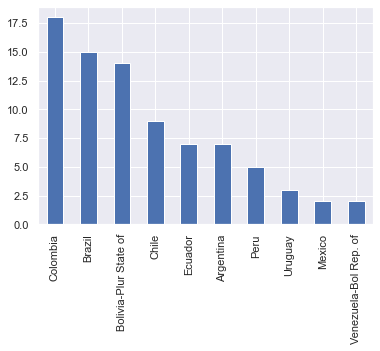

In [28]:
fiscal_policy['país'].value_counts().plot(kind='bar')

In [162]:
monetary_policy['país'].value_counts().plot(kind='bar')

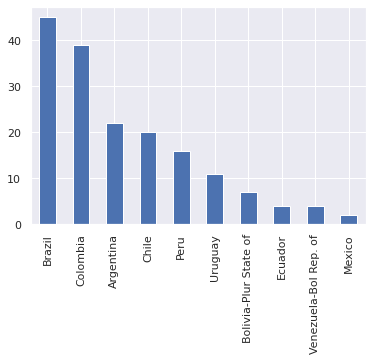

In [163]:
business_policy['país'].value_counts().plot(kind='bar')